some basic todos resulting from this:

+ Get together a clear model & method, understand the code and the simulations you are running
+ Clarify for yourself how the coefficients in a differential equation thing should match to my model

In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict

In [9]:
from itertools import groupby

In [55]:
from random import random as rnd

In [51]:
# network and group sizes
N = 500
p1 = 0.1

N1 = int(N*p1)
N2 = N-N1

# p(inf | mode1, mode2 interaction)
b = {
    1:1,
    2:0.3
}

# interaction within and between groups
p11, p12, p22 = 0.8, 0.1, 0.3

# g1, g2, mode
p = {
    (1,1,1): 0.8,
    (1,2,1): 0.1,
    (2,2,1): 0.3,
    (1,1,2): 0.25,
    (1,2,2): 0.1,
    (2,2,2): 0.25,
}

# determine groups

In [62]:
grp = [
    1 + (ii >= N1)
    for ii in ns
]

In [63]:
g = defaultdict(set)
for ii in ns:
    g[ grp[ii] ].add(ii)

# random mixing with probabilities...

In [64]:
es = []
ns = list(range(N))

In [65]:
for i in ns:
    for j in ns:
        if i >= j: continue
        
        for mode in (1,2):
            if rnd() < p[ (grp[i], grp[j], mode) ]:
                es.append( (i,j, mode) )

In [ ]:
es[:20]

[(0, 1, 1),
 (0, 2, 1),
 (0, 3, 1),
 (0, 4, 1),
 (0, 5, 1),
 (0, 7, 1),
 (0, 8, 1),
 (0, 9, 1),
 (0, 10, 1),
 (0, 11, 1),
 (0, 11, 2),
 (0, 12, 2),
 (0, 13, 1),
 (0, 14, 1),
 (0, 15, 1),
 (0, 15, 2),
 (0, 16, 1),
 (0, 17, 1),
 (0, 18, 1),
 (0, 19, 1)]

In [126]:
# aggregate across multiple independent probabilities [is this correct?]
es_tot = [
    (a1,a2, 1 - np.product( [(1-b[mode]) for (a1,a2,mode) in g] ))
    for (a1,a2), g in groupby(sorted(es), key=lambda x:x[:2])
]

In [127]:
len(es), len(es_tot)

(61149, 53141)

In [128]:
G = nx.Graph()

In [129]:
G.add_nodes_from(ns)
G.add_weighted_edges_from(es_tot)

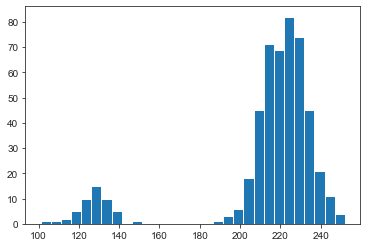

In [130]:
plt.hist( dict(nx.degree(G)).values(), bins=30 );

# try to simulate some disease spreading

In [131]:
from epi_model import *

In [132]:
from random import sample

In [133]:
net = weightedNetwork(ns, es_tot)

In [134]:
#sim = SEIR_daily(net, {'s2e':1, 'e2i':0.01, 'i2r':0})
sim = SEIR_daily(net, params.covid_estimate)

In [135]:
for ii in sample(ns, int(N*0.2)):
    sim.state_change(ii, 'inf')
sim.run(50)

In [101]:
sim.state_changes?

Type:        list
String form: [(0, 184, 'inf'), (0, 367, 'inf'), (0, 302, 'inf'), (0, 333, 'inf'), (0, 103, 'inf'), (0, 26, 'in <...>  'exp'), (48, 214, 'inf'), (48, 450, 'inf'), (49, 285, 'exp'), (49, 371, 'exp'), (49, 29, 'rec')]
Length:      441
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.


In [75]:
params.covid_estimate

{'s2e': 0.0006, 'e2i': 2.3148148148148147e-05, 'i2r': 1.6534391534391536e-05}

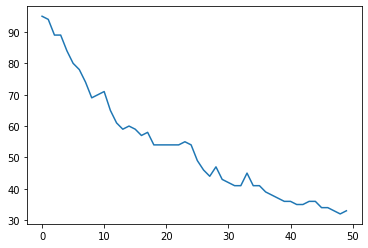

In [21]:
plt.plot( sim.meas['inf'] )

# and with seirsplus

In [27]:
from seirsplus.models import *
from seirsplus.networks import *

+ beta     rate of transmission     float     REQUIRED
+ sigma     rate of progression     float     REQUIRED
+ gamma     rate of recovery     float     REQUIRED
+ xi     rate of re-susceptibility     float     0
+ mu_I     rate of infection-related mortality     float     0
+ mu_0     rate of baseline mortality     float     0
+ nu     rate of baseline birth     float     0
+ beta_Q     rate of transmission for detected cases     float     None (set equal to beta)
+ sigma_Q     rate of progression for detected cases     float     None (set equal to sigma)
+ gamma_Q     rate of recovery for detected cases     float     None (set equal to gamma)
+ mu_Q     rate of infection-related mortality for detected cases     float     None (set equal to mu_I)
+ theta_E     rate of testing for exposed individuals     float     0
+ theta_I     rate of testing for infectious individuals     float     0
+ psi_E     probability of positive tests for exposed individuals     float     0
+ psi_I     probability of positive tests for infectious individuals     float     0
+ initN     initial total number of individuals     int     10
+ initI     initial number of infectious individuals     int     10
+ initE     initial number of exposed individuals     int     0
+ initQ_E     initial number of detected exposed individuals     int     0
+ initQ_I     initial number of detected infectious individuals     int     0
+ initR     initial number of recovered individuals     int     0
+ initF     initial number of deceased individuals     int     0

In [136]:
SIGMA  = 1/5.2
GAMMA  = 1/10
MU_I   = 0.002

R0     = 2.5
BETA   = 1/(1/GAMMA) * R0
BETA_Q = 0.5*BETA

P      = 0.2
Q      = 0.05

In [137]:
model = SEIRSNetworkModel(G       = G, 
                          beta    = BETA, 
                          sigma   = SIGMA, 
                          gamma   = GAMMA, 
                          mu_I    = MU_I,
                          mu_0    = 0, 
                          nu      = 0, 
                          xi      = 0,
                          p       = P,
                          G_Q     = G, 
                          beta_Q  = BETA_Q, 
                          sigma_Q = SIGMA,
                          gamma_Q = GAMMA, 
                          mu_Q    = MU_I,
                          theta_E = 0, 
                          theta_I = 0, 
                          phi_E   = 0, 
                          phi_I   = 0, 
                          psi_E   = 0, 
                          psi_I   = 0,
                          q       = Q,
                          initI   = numNodes/100, 
                          initE   = 0, 
                          initQ_E = 0, 
                          initQ_I = 0, 
                          initR   = 0, 
                          initF   = 0)

/Users/alecmcgail/envs/epi/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


In [138]:
checkpoints = {'t':       [20, 100], 
               'G':       [G_distancing, G_normal], 
               'p':       [0.5*P, P], 
               'theta_E': [0.02, 0.02], 
               'theta_I': [0.02, 0.02], 
               'phi_E':   [0.2, 0.2], 
               'phi_I':   [0.2, 0.2]}

In [139]:
model.run(T=300, checkpoints=checkpoints)

t = 0.02
t = 10.01
[Checkpoint: Updating parameters]
t = 20.01
t = 30.13
t = 40.05
t = 50.03
t = 60.16
t = 70.21
t = 80.29
t = 90.27
[Checkpoint: Updating parameters]


True

/Users/alecmcgail/envs/epi/lib/python3.8/site-packages/seirsplus/models.py:1562: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


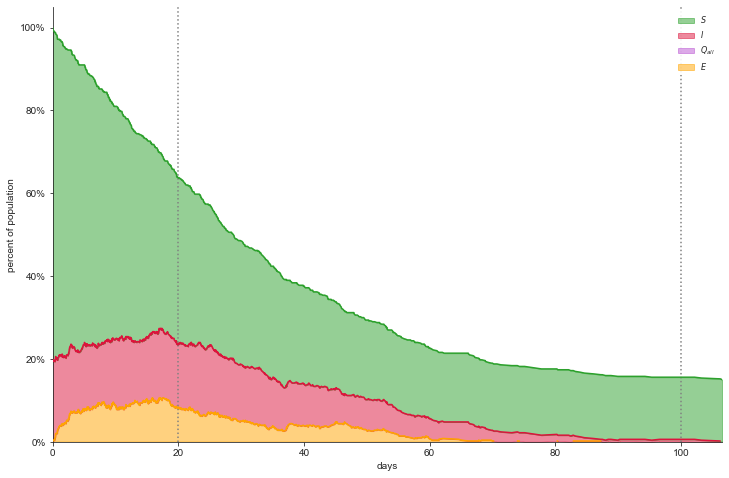

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='days', ylabel='percent of population'>)

In [144]:
model.figure_infections(vlines=checkpoints['t'], plot_S='stacked', plot_R='stacked')

In [145]:
layout = nx.spring_layout(G, iterations=50)

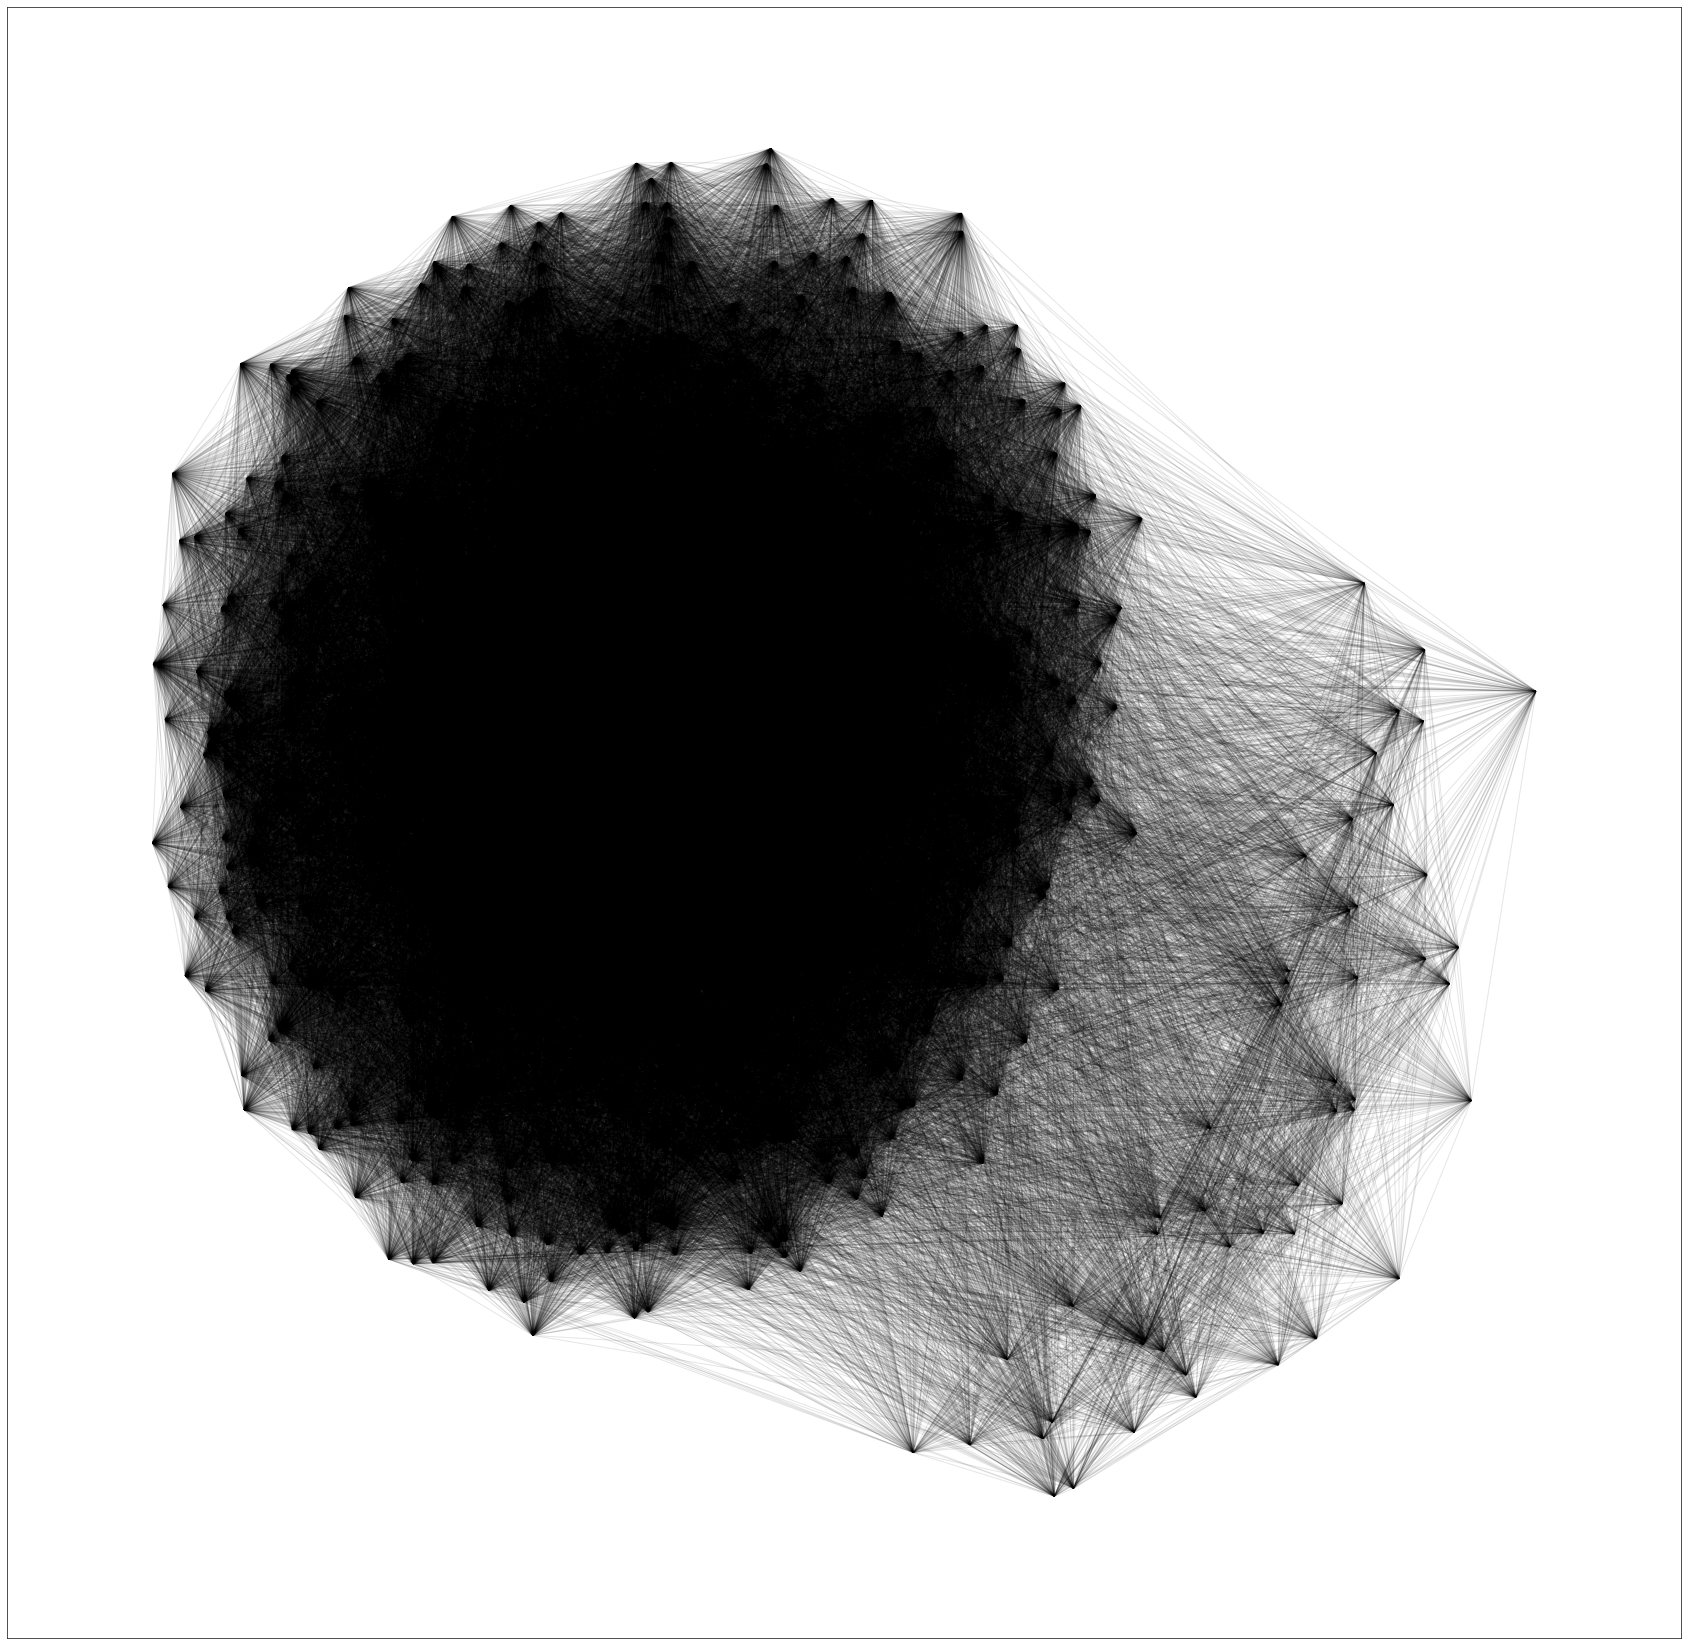

In [146]:
plt.figure(figsize=(30,30))
nx.draw_networkx_edges(G, pos=layout, alpha=0.1)